In [171]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
# Define the sigma function
def sigma(altitude):
    a = 1
    b = 0.05
    return a * (1 - np.exp(-b * altitude))


# Simulate the sensor model to create an observation matrix z
def sensor_model(true_matrix, altitude):
    sig = sigma(altitude)
    P_z_equals_m = 1 - sig
    P_z_not_equals_m = sig

    rows, cols = true_matrix.shape
    observation_matrix = np.zeros((rows, cols))

    for i in range(rows):
        for j in range(cols):
            if true_matrix[i, j] == 1:
                observation_matrix[i, j] = np.random.choice([1, 0], p=[P_z_equals_m, P_z_not_equals_m])
            else:
                observation_matrix[i, j] = np.random.choice([0, 1], p=[P_z_equals_m, P_z_not_equals_m])

    return observation_matrix

# Calculate true positive, false negative, etc.
def calculate_statistics_(true_matrix, observation):
    true_positive = np.sum((true_matrix == 1) & (observation ==1))
    false_negative = np.sum((true_matrix == 1) & (observation ==0))
    false_positive = np.sum((true_matrix == 0) & (observation == 1))
    true_negative = np.sum((true_matrix == 0) & (observation ==  0))
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # accuracy = (true_positive + true_negative) / true_matrix.size
    
    return {
        'True Positive': true_positive,
        'False Negative': false_negative,
        'False Positive': false_positive,
        'True Negative': true_negative,
        'F1 Score': f1_score,
        # 'Accuracy': accuracy
        }

In [172]:
# Sample the sensor model N times and geenrate observation matrix
def sampler(true_matrix, altitude, N):
    cumulative_observation = np.empty((0,2))
    # cumulative_observation = np.zeros((N, rows, cols), dtype=int)
    for i in range(N):
        observation_matrix = sensor_model(true_matrix, altitude)
        cumulative_observation = np.vstack([cumulative_observation, observation_matrix])
    return cumulative_observation

In [186]:
N_max = 100
hs = [ 5.41, 10.83, 16.24, 21.65, 27.06, 32.48]

N_values = list(range(1, N_max+1, 1))

true_matrix = np.array([0,1])
true_matrix = np.expand_dims(true_matrix, axis=0)
N_values = N_values[0:int(len(N_values)/2)]
N0 = N_max/2
N1 = N_max/2

In [188]:
alt_dict = {}
all_data = {}
# N_max = 3
# N_values = list(range(1, N_max+1, 1))
for i, altitude in enumerate(hs):
    alt_dict={}
    for N in N_values:
        observation = sampler(true_matrix, altitude, N)
        stats = calculate_statistics_(true_matrix, observation)
        alt_dict[2*N]={
            "S":    round(sigma(altitude), 2),
            "FP":   round(stats["False Positive"]/N,  2),
            "FN":   round(stats["False Negative"]/N,  2),
            "TN":   round(stats["True Negative"]/N,   2),
            "TP":   round(stats["True Positive"]/N,   2),
            "1-S":  round(1-sigma(altitude), 2),
            }
        # print(f'obs: {observation}')
        # print(f"stat {stats}")

    all_data[altitude] = alt_dict
    # break
        

In [190]:
metrics = ["FP", "FN", "TN", "TP"]
variability = {metric: [] for metric in metrics}
print(all_data.keys())
for alt in hs:
    samples = all_data[alt]
    sample_numbers = sorted(samples.keys()) 
    # print(samples)
    # break
    # for 
    for metric in metrics:
        values = [samples[n][metric] for n in sample_numbers]
        std_dev = np.std(values)
        variability[metric].append(std_dev)
    #     print(f"alt {alt}, metric {metric}, valuies {values}")
    #     print(f"std dev {std_dev}")
    #     print(f"var : {variability[metric]}")
    #     # break
    # break
print(variability)

dict_keys([5.41, 10.83, 16.24, 21.65, 27.06, 32.48])
{'FP': [0.10307453613769019, 0.14464909263455478, 0.12611122075374576, 0.1782743952450828, 0.14713599151805107, 0.0964367150000455], 'FN': [0.1191007976463634, 0.1572235351338978, 0.12522635505355892, 0.1387452341523845, 0.1722766379983078, 0.09830178024837596], 'TN': [0.10307453613769019, 0.14464909263455475, 0.12611122075374576, 0.1782743952450828, 0.14713599151805107, 0.0964367150000455], 'TP': [0.11910079764636339, 0.1572235351338978, 0.1252263550535589, 0.1387452341523845, 0.17227663799830784, 0.09830178024837596]}


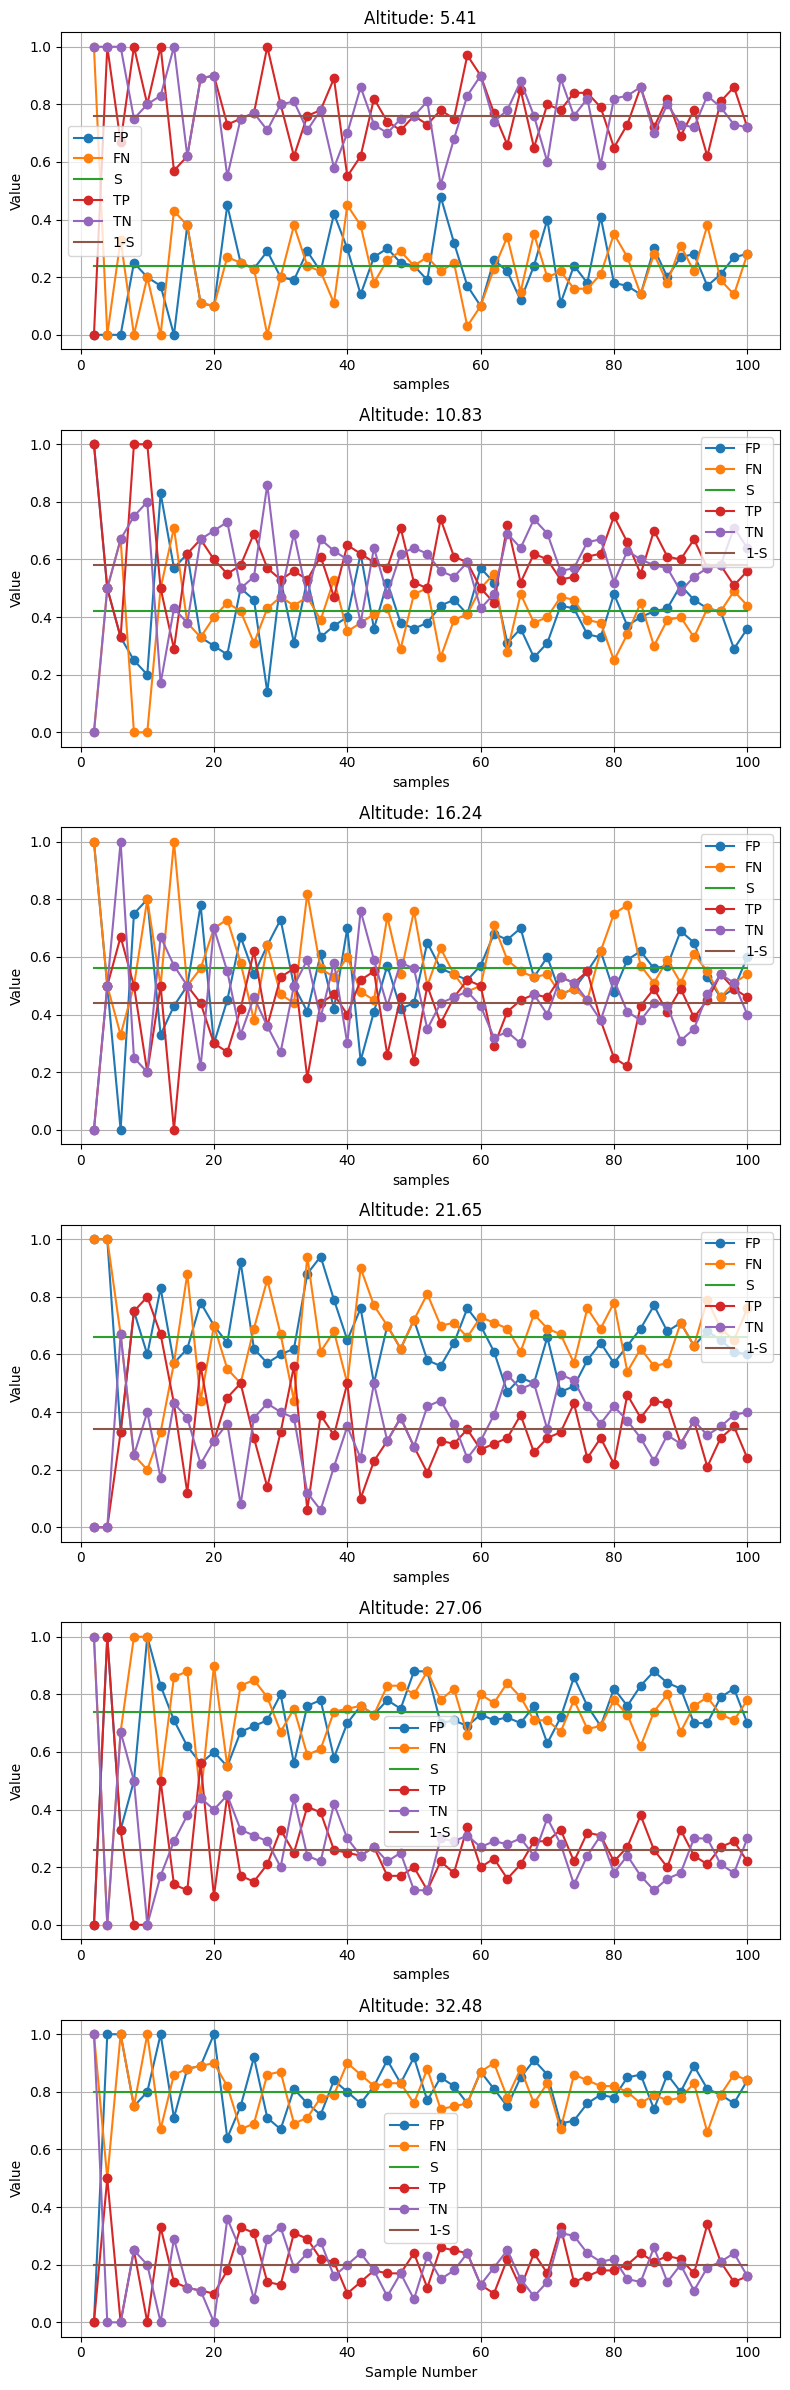

In [167]:

# Prepare data for plotting
altitudes = list(all_data.keys())

# Create subplots for each altitude
fig, axes = plt.subplots(len(altitudes), 1, figsize=(8, 4 * len(altitudes)), sharex=False)

# Plot for each altitude
for idx, altitude in enumerate(altitudes):
    samples = all_data[altitude]
    sample_numbers = sorted(samples.keys())
    
    # Extract values for FP, FN, S, TP, TN, and 1-S
    FP  = [samples[n]['FP'] for n in sample_numbers]
    FN  = [samples[n]['FN'] for n in sample_numbers]
    S   = [samples[n]['S']  for n in sample_numbers]
    TP  = [samples[n]['TP'] for n in sample_numbers]
    TN  = [samples[n]['TN'] for n in sample_numbers]
    one_minus_S = [samples[n]['1-S'] for n in sample_numbers]
    
    # Plot FP, FN, S, TN, TP, and 1-S
    ax = axes[idx]
    ax.plot(sample_numbers, FP, label='FP', marker='o')
    ax.plot(sample_numbers, FN, label='FN', marker='o')
    ax.plot(sample_numbers, S,  label='S',) # marker='o')
    ax.plot(sample_numbers, TP, label='TP', marker='o')
    ax.plot(sample_numbers, TN, label='TN', marker='o')
    ax.plot(sample_numbers, one_minus_S, label='1-S',) #marker='o')
    
    ax.set_title(f'Altitude: {altitude}')
    ax.set_ylabel('Value')
    ax.set_xlabel('samples')
    ax.grid(True)
    ax.legend(loc='best')

# Set common x-label
plt.xlabel('Sample Number')
plt.tight_layout()
plt.show()
